In [1]:
from copy import deepcopy
import pandas as pd
import numpy as np

from src.features.build_features import StockTechnicals

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
# load data using MSFT 
ticker = "MSFT"
all_daily_data = pd.read_csv(f'../data/{ticker}.csv')

In [3]:
# set up our X and y

N = 26

# create a feature matrix and some labels using our handy StockTechnicals class
technicals = StockTechnicals(all_daily_data)
X = technicals.features
y = technicals.future_sma_higher_than_current_price(N)

# we don't have the last N days of data
y = y[~np.isnan(y)]
X = X[:len(y)]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, stratify=y)


/Users/ted/Library/Caches/pypoetry/virtualenvs/njit-ml-scratch-l36YVstm-py3.7/lib/python3.7/site-packages/ta/trend.py:567: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/Users/ted/Library/Caches/pypoetry/virtualenvs/njit-ml-scratch-l36YVstm-py3.7/lib/python3.7/site-packages/ta/trend.py:571: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [4]:
# take a look at the relative importances of all features using a random forest 
feat_labels = list(X.columns)
forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print(f"{f + 1:2}) {X.columns[indices[f]]:<28} {round(importances[indices[f]], 4):>}")

 1) trend_visual_ichimoku_b      0.0469
 2) volume_obv                   0.0377
 3) volume_nvi                   0.0346
 4) trend_ichimoku_b             0.0268
 5) trend_visual_ichimoku_a      0.0265
 6) trend_mass_index             0.0249
 7) others_cr                    0.0241
 8) volume_adi                   0.0237
 9) trend_ema_slow               0.0226
10) trend_sma_slow               0.0217
11) momentum_kama                0.0216
12) volatility_atr               0.0209
13) trend_adx                    0.02
14) trend_kst_diff               0.02
15) volatility_bbw               0.0198
16) volatility_bbh               0.0197
17) volatility_kcw               0.0188
18) volatility_bbl               0.0182
19) trend_kst_sig                0.0182
20) volume_cmf                   0.0181
21) trend_ichimoku_a             0.018
22) trend_macd_diff              0.0177
23) trend_trix                   0.0176
24) trend_ema_fast               0.0174
25) volatility_dcl               0.0167
26) v

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

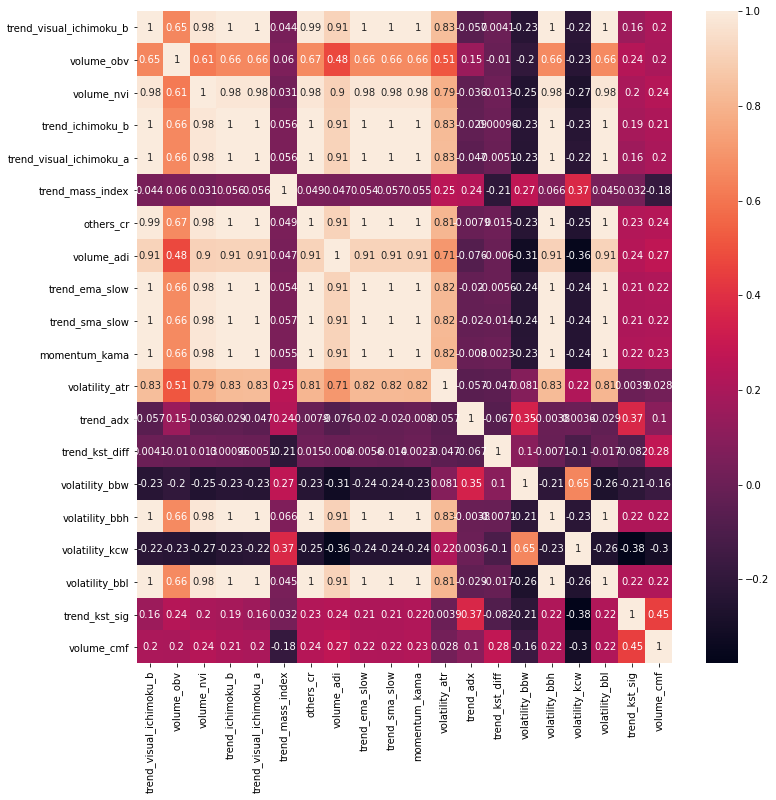

In [6]:
# check the top 20 features to see if any are correlated
top_feats_X = X_train.iloc[:,indices[:20]]
corr = top_feats_X.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot = True, label = ticker)

In [7]:
# there are lots of correlated features, so let's remove them in order of priority
ind_feats = []
for i in indices:
    # iterating in importance order, don't include a feature if it has a correlation
    # stronger than 0.9 (or -0.9) with a features already included
    if all(abs(X_train.corr().iloc[ind_feats, i]) < 0.9):
        ind_feats.append(i)

print(f'We are left with {len(ind_feats)} "independent" (non-correlated) features')

We are left with 41 "independent" (non-correlated) features


In [8]:
# observe feature importances of this subset using a new random forest
ind_feats_X = X_train.iloc[:, ind_feats]

ind_feats_forest = RandomForestClassifier(n_estimators=500, random_state=1)
ind_feats_forest.fit(ind_feats_X, y_train)
ind_importances = ind_feats_forest.feature_importances_

for rk, (idx, imp) in enumerate(sorted(zip(ind_feats, ind_importances), key=lambda x: x[1], reverse=True)):
    print(f"{rk + 1:2}) {X.columns[idx]:<28} {round(imp, 4):>}")

 1) trend_visual_ichimoku_b      0.0981
 2) volume_obv                   0.0582
 3) volatility_kcw               0.0436
 4) volatility_atr               0.042
 5) trend_mass_index             0.041
 6) trend_kst_sig                0.0397
 7) volume_cmf                   0.0384
 8) trend_adx                    0.038
 9) trend_macd_signal            0.0376
10) volatility_bbw               0.0365
11) trend_kst_diff               0.0362
12) momentum_tsi                 0.0327
13) trend_macd_diff              0.0311
14) trend_adx_pos                0.0279
15) volume_sma_em                0.0272
16) trend_adx_neg                0.0253
17) volume_vpt                   0.0248
18) volume_fi                    0.0245
19) momentum_roc                 0.0223
20) momentum_mfi                 0.0219
21) momentum_rsi                 0.0218
22) trend_vortex_ind_neg         0.0212
23) momentum_uo                  0.021
24) trend_aroon_ind              0.0209
25) trend_dpo                    0.0202
26) 

In [9]:
# Setting a threshold of 0.3 leaves us with 13 indicators as featres, which 
# sounds like a good place to start

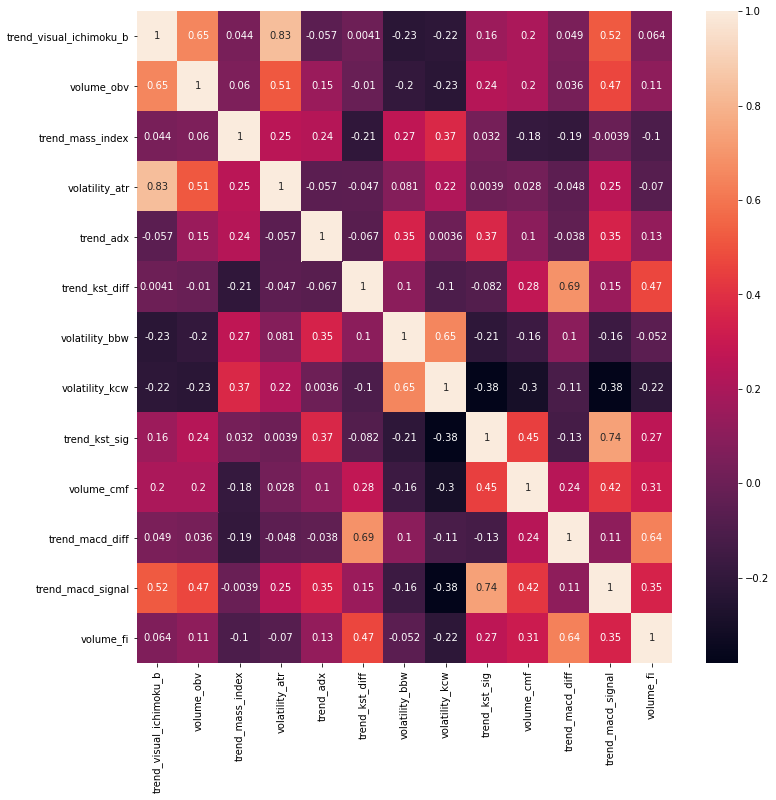

In [10]:
# Take a look again at the correlation matrix of our top 13 features to make sure nothing changed
top_feats_X = X_train.iloc[:,ind_feats[:13]]
corr = top_feats_X.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot = True, label = ticker)

